# EDA - Predict Future Sales

Final project for "How to win a data science competition" Coursera course

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [3]:
from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

In [4]:
import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

### Helper functions

In [5]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

### Read in data from CSV files

In [6]:
mydateparser = lambda x: datetime.strptime(x, "%d.%m.%Y")

In [7]:
cats = (
    pd.read_csv("data/item_categories.csv", sep=',', header=0, encoding='utf-8')
    .sort_values(by='item_category_id')
    .set_index("item_category_id", drop=True))
items = (
    pd.read_csv("data/items.csv", sep=',', header=0, encoding='utf-8')
    .sort_values(by=['item_id', 'item_category_id'])
    .set_index(['item_id', 'item_category_id'], drop=True))
train = (
    pd.read_csv("data/sales_train.csv", sep=',', header=0, encoding='utf-8',
                parse_dates=['date'], 
                date_parser=mydateparser))
shops = (
    pd.read_csv("data/shops.csv", sep=',', header=0, encoding='utf-8')
    .sort_values(by=['shop_id'])
    .set_index(['shop_id'], drop=True))
test = (
    pd.read_csv("data/test.csv", sep=',', header=0, encoding='utf-8')
    .sort_values(by='ID')
    .set_index('ID'))
sample_submission= (
    pd.read_csv("data/sample_submission.csv", sep=',', header=0, encoding='utf-8')
    .sort_values(by='ID')
    .set_index('ID'))

In [8]:
cats.head(2)

,item_category_name
item_category_id,
0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2


In [9]:
items.head(2)

,,item_name
item_id,item_category_id,
0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D
1,76,!ABBYY FineReader 12 Professional Edition Full...


In [10]:
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0


In [11]:
shops.head(2)

,shop_name
shop_id,
0,"!Якутск Орджоникидзе, 56 фран"
1,"!Якутск ТЦ ""Центральный"" фран"


In [12]:
test.head(2)

,shop_id,item_id
ID,,
0,5,5037
1,5,5320


### Daily Sales

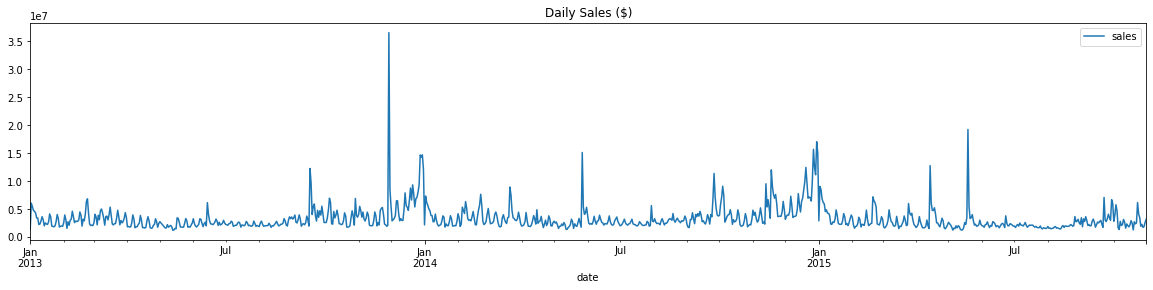

In [12]:
(
    train
    .query("item_cnt_day>0")
    .query("item_price>0")
    .assign(sales = lambda x: x.item_price*x.item_cnt_day)
    .groupby('date')
    .aggregate({'sales':'sum'})
    .plot(figsize=(20,4), title='Daily Sales ($)')
)

plt.show()

### Daily Sales by date block

It looks like date blocks may correspond to calendar months

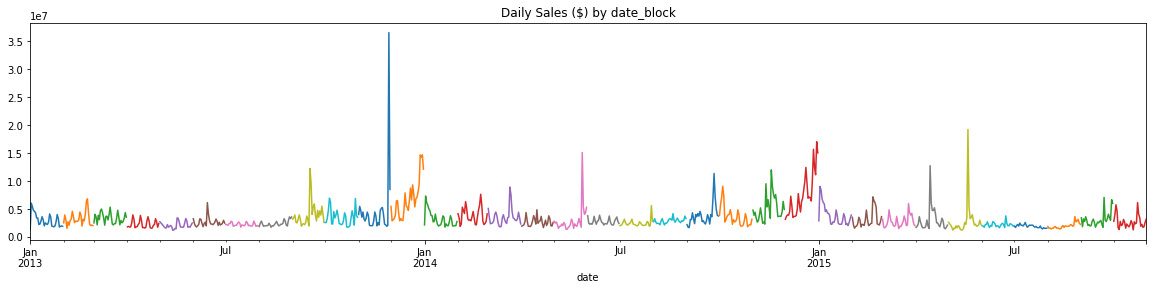

In [11]:
(
    train
    .query("item_cnt_day>0")
    .query("item_price>0")
    .assign(sales = lambda x: x.item_price*x.item_cnt_day)
    .pivot_table(index='date',columns='date_block_num',values='sales', aggfunc='sum')
    .plot(figsize=(20,4), title='Daily Sales ($) by date_block', legend=False)
)

plt.show()

### Are date blocks like months?

Let's see if the date block numbers are sequential with the date, and non overlapping.  If so, then we should see a single stair step pattern in the below graph.  The min_block_num (blue) and the max_block_num (orange) lines should perfectly overlap.

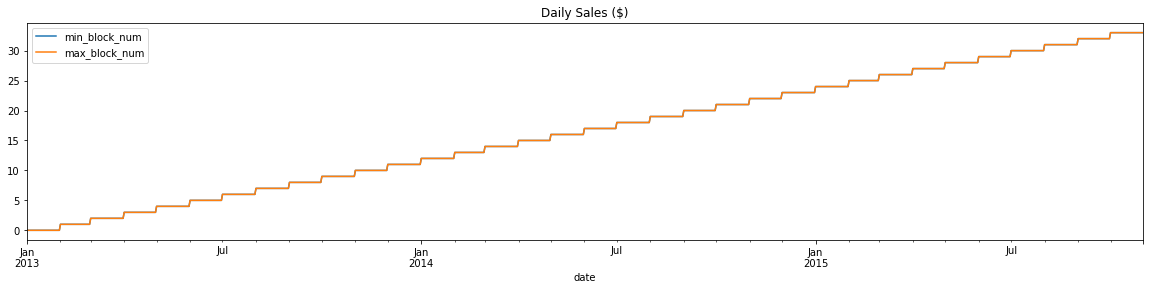

In [18]:
(
    train
    .query("item_cnt_day>0")
    .query("item_price>0")
    .assign(min_block_num = lambda x: x.date_block_num)
    .assign(max_block_num = lambda x: x.date_block_num)
    .groupby('date')
    .aggregate({'min_block_num':'min', 'max_block_num':'max'})
    .plot(figsize=(20,4), title='Daily Sales ($)')
)

plt.show()

### Average daily sales per date block

Text(0.5, 1.0, 'Average daily sales per date_block_num')

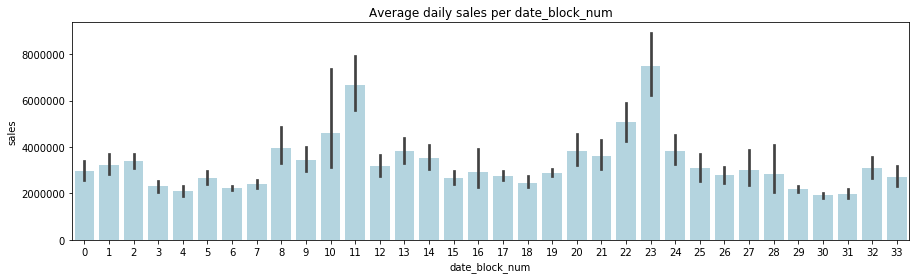

In [21]:
fig, ax = plt.subplots( figsize=(15, 4) )

daily_sales = (train
               .assign(sales=lambda x: x.item_price*x.item_cnt_day)
               .groupby(['date','date_block_num'])
               .aggregate({'sales':np.sum})
               .reset_index() )

sns.barplot(ax=ax,color='lightblue',
            x= daily_sales.date_block_num, 
            y=daily_sales.sales)
plt.title("Average daily sales per date_block_num")

### Sales per shop

Text(0.5, 1.0, 'Total daily sales per shop')

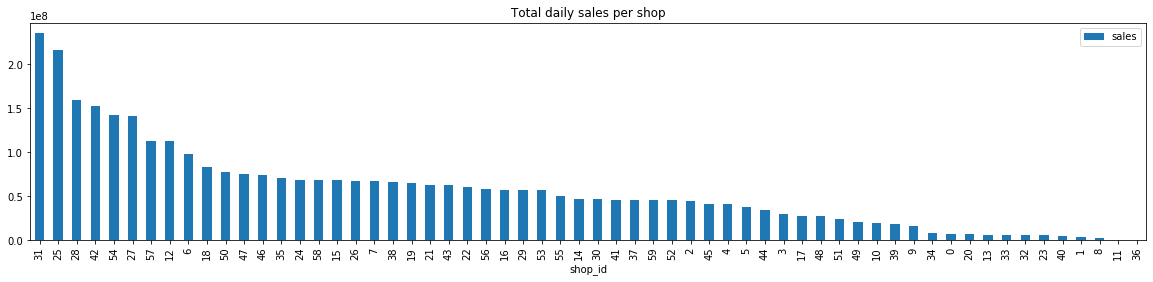

In [39]:
fig, ax = plt.subplots( figsize=(20, 4) )

daily_sales = (train
               .assign(sales=lambda x: x.item_price*x.item_cnt_day)
               .groupby(['shop_id'])
               .aggregate({'sales':np.sum})
               .sort_values(by='sales', ascending=False)
               .plot.bar(ax=ax) )

plt.title("Total daily sales per shop")

Text(0.5, 1.0, 'Daily sales per shop')

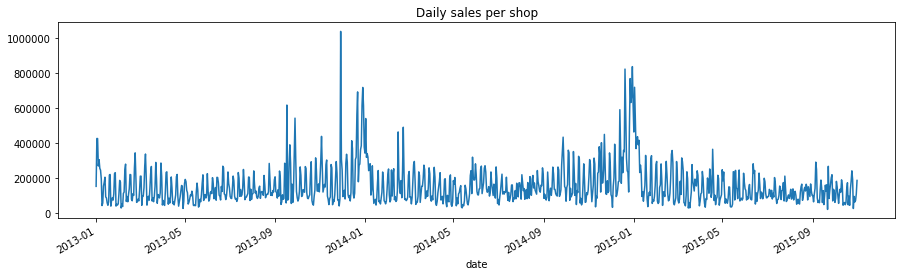

In [38]:
fig, ax = plt.subplots( figsize=(15, 4) )

daily_sales = (train
               .query("shop_id==28")
               .assign(sales=lambda x: x.item_price*x.item_cnt_day)
               .pivot_table(index='date', columns='shop_id', values='sales', aggfunc='sum')
               .plot(ax=ax, legend=False))

plt.title("Daily sales per shop")

### Explore items sold in shop_id 9

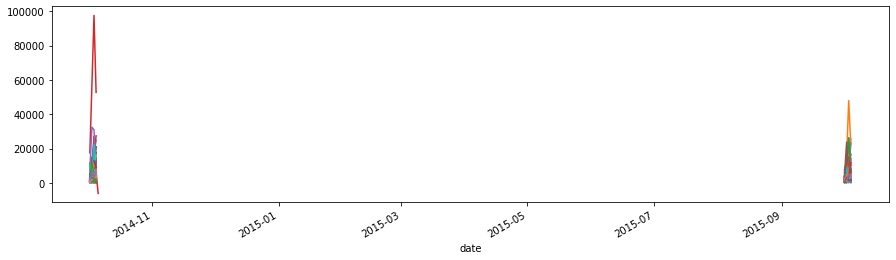

In [27]:
fig, ax = plt.subplots( figsize=(15, 4) )

daily_sales = (train
               .query("shop_id==20")
#                .query("item_id in(3751,3732,3734,6457,6675)")
               .assign(sales=lambda x: x.item_price*x.item_cnt_day)
               .pivot_table(index='date', columns='item_id', values='sales', aggfunc='sum')
               .plot(ax=ax, legend=False)
              )

### Explore data

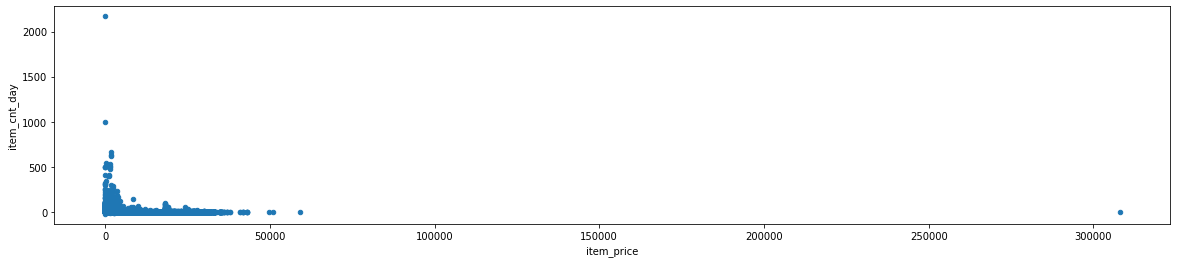

In [14]:
(
    train
    .filter(['item_price','item_cnt_day'])
    .plot.scatter(x='item_price', y='item_cnt_day', figsize=(20,4))
)

plt.show()

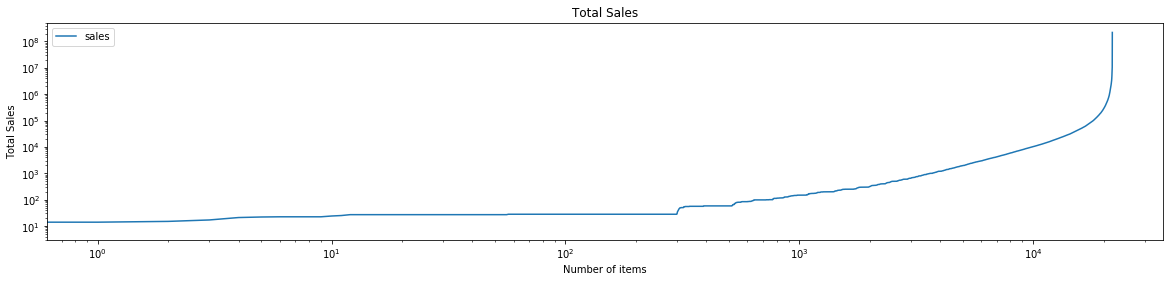

In [14]:
(
    train
    .query("item_cnt_day>0")
    .query("item_price>0")
    .assign(sales = lambda x: x.item_price*x.item_cnt_day)
    .groupby(['item_id'])
    .aggregate({'sales':np.sum})
    .sort_values(by='sales')
    .reset_index(drop=True)
    .plot(loglog=True, figsize=(20,4))
)

plt.xlabel("Number of items")
plt.ylabel("Total Sales")
plt.title("Total Sales")
plt.show()

In [15]:
train.query("(item_price>=100000) or (item_price<0)")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [16]:
train.query("(item_cnt_day>1000) or (item_cnt_day<0)")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,2013-01-05,0,25,2552,899.0,-1.0
148,2013-01-23,0,25,2321,999.0,-1.0
175,2013-01-07,0,25,2199,1449.0,-1.0
807,2013-01-02,0,25,2330,599.0,-1.0
1041,2013-01-13,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.0,-1.0
2934462,2015-10-18,33,25,4896,6398.0,-1.0
2935263,2015-10-05,33,25,10039,249.0,-1.0
2935643,2015-10-16,33,25,7893,2990.0,-1.0


In [66]:
shops.sort_values(by='shop_name')

,shop_name
shop_id,
0,"!Якутск Орджоникидзе, 56 фран"
1,"!Якутск ТЦ ""Центральный"" фран"
2,"Адыгея ТЦ ""Мега"""
3,"Балашиха ТРК ""Октябрь-Киномир"""
4,"Волжский ТЦ ""Волга Молл"""
5,"Вологда ТРЦ ""Мармелад"""
6,"Воронеж (Плехановская, 13)"
7,"Воронеж ТРЦ ""Максимир"""
8,"Воронеж ТРЦ Сити-Парк ""Град"""
